# Linear Regression : 로지스틱 회귀
> 이진 분류 (binary classification)에서 사용하는 regression의 방법

## Outline

* [1. 로지스틱 회귀](#1logisticregression)
    * [1-1. 문제 상황](#1-1)
    * [1-2. 데이터 미리보기](#1-2)
    * [1-3. 시그모이드 함수](#1-3)
    * [1-4. 로지스틱 회귀를 위한 비용함수](#1-4)
    * [1-5. 로지스틱 회귀에서의 경사하강법](#1-5)
    * [1-6. 결정 범위를 시각화](#1-6)
    * [1-7. 로지스틱 회귀 분석 예측 결과](#1-7)

### Module Import & Load data

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from resource_W3.utils import *
import copy
import math
%matplotlib inline

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [5]:
# load dataset
X_train, y_train = load_data("./resource_W3/data/ex2data1.txt")

## 1_logistic_regression

### 1-1. 문제 상황
* 대학 입학 관리자 입장에서, 학생의 대학 입학 여부를 예측하는 로지스틱 회귀 모형을 만들고자 함
* 각 훈련 example에는 입학 지원자의 2가지 시험 점수와 입학 결정 여부가 주어짐
* 위 내용으로 입학 지원자의 입학 여부 분류를 예측하기

### 1-2. 데이터 미리보기

In [8]:
# X train
print("X_train 5가지:\n", X_train[:5])
print("Type of X_train:",type(X_train))

X_train 5가지:
 [[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]]
Type of X_train: <class 'numpy.ndarray'>


In [10]:
# y train
print("y_train 5가지:\n", y_train[:5])
print("Type of y_train:",type(y_train))

y_train 5가지:
 [0. 0. 0. 1. 1.]
Type of y_train: <class 'numpy.ndarray'>


In [13]:
# X train, y train의 shape
print ('The shape of X_train: ' + str(X_train.shape))
print ('The shape of y_train: ' + str(y_train.shape))
print ('training example의 수 m = %d' % (len(y_train)))

The shape of X_train: (100, 2)
The shape of y_train: (100,)
training example의 수 m = 100


* 시각화

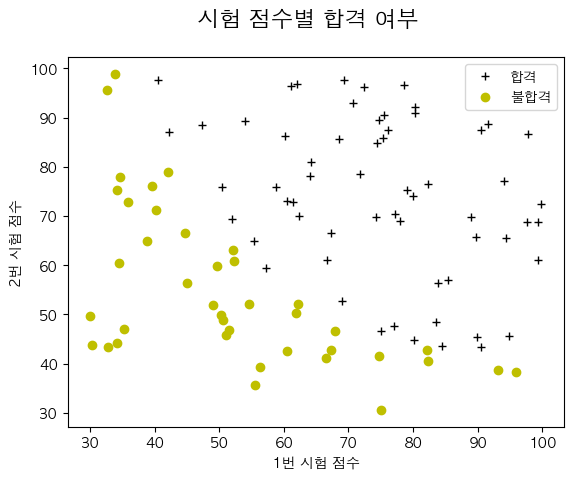

In [18]:
# Plot examples
plot_data(X_train, y_train[:], pos_label="합격", neg_label="불합격")

plt.suptitle('시험 점수별 합격 여부', fontsize=16)
plt.ylabel('2번 시험 점수') 
plt.xlabel('1번 시험 점수') 
plt.legend(loc="upper right")
plt.show()

### 1-3. Sigmoid function
1. 회귀식 정의
$$ f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)$$

2. 함수 안에 함수 (activation) : z = f(x)
$$g(z) = \frac{1}{1+e^{-z}}$$

* sigmoid 함수 구현하기

In [64]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """
          
    g = 1/(1+np.exp(-z))
    
    return g

# UNIT TESTS
from resource_W3.public_tests import *
sigmoid_test(sigmoid)

All tests passed!


* 시각화
    - x가 0일때 sigmoid 함수는 0.5를 지난다
    - 0 ~ 1 사이의 범위를 가진다

In [65]:
print("sigmoid(0) = " + str(sigmoid(0)))

sigmoid(0) = 0.5


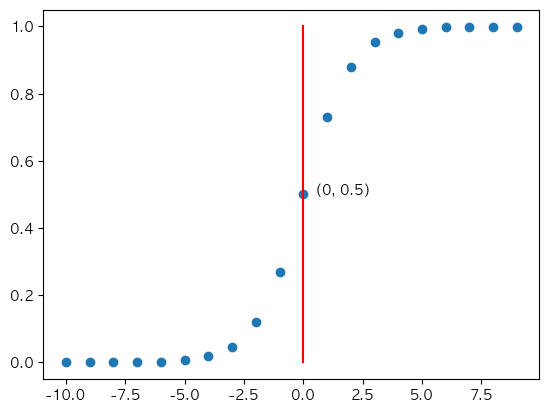

In [66]:
plt.scatter(np.array(range(-10, 10)),sigmoid(np.array(range(-10, 10))))
plt.plot([0,0], [0, 1], c='r')
plt.text(0.5, sigmoid(0), '(0, 0.5)')
plt.show()

### 1-4. 로지스틱 회귀를 위한 비용함수

1. cost(비용)을 계산하는 함수 만들기
$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$
* loss(오차)의 평균

2. loss의 정의
$$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
* 예측이 1일 때는 
$$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), 1) = - \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)$$
* 예측이 0일 때는 
$$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), 0) = - \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)$$

In [67]:
def compute_cost(X, y, w, b, lambda_= 1):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : scalar Values of bias parameter of the model
      lambda_: unused placeholder
    Returns:
      total_cost: (scalar)         cost 
    """

    m, n = X.shape

    z = np.sum(X*w, axis=1)+b
    g = sigmoid(z)
    total_cost = np.sum(-y*np.log(g) - (1-y)*np.log(1-g))/m

    return total_cost

compute_cost_test(compute_cost)

All tests passed!


### 1-5. 로지스틱 회귀에서의 경사하강법

* 선형회귀와 방식이 동일함
$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

* b, w를 각각 편미분
$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$

In [68]:
# 업데이트 할 (미분한) b, w 값 계산
def compute_gradient(X, y, w, b, lambda_=None): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value 
      w : (array_like Shape (n,1)) values of parameters of the model      
      b : (scalar)                 value of parameter of the model 
      lambda_: unused placeholder.
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    for i in range(m):
        z_wb = 0
        for j in range(n): 
            z_wb += X[i, j] * w[j]
        z_wb += b
        f_wb = sigmoid(z_wb)
        
        dj_db_i = f_wb - y[i]
        dj_db += dj_db_i
        
        for j in range(n):
            dj_dw[j] += (f_wb - y[i])* X[i][j]

    dj_dw = dj_dw / m
    dj_db = dj_db / m
        
    return dj_db, dj_dw

compute_gradient_test(compute_gradient)

All tests passed!


* 경사하강법 전체 (반복해서 비용 계산 후 비용을 가장 감소시키는 지점 찾기)

In [69]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant
      
    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # training 수
    m = len(X)
    
    # 비용과 기울기 기록
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # w,b 계산
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # 업데이트
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # 비용 계산
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # 반복이 총 반복 횟수의 1/10 단위가 된 경우나 총 반복 개수의 -1 이 된 경우 결과 출력 
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"반복 횟수 {i:4}: 비용 {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [74]:
np.random.seed(1)
initial_w = 0.01 * (np.random.rand(2).reshape(-1) - 0.5)
initial_b = -8

# Some gradient descent settings
iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations, 0)

반복 횟수    0: 비용     0.96   
반복 횟수 1000: 비용     0.31   
반복 횟수 2000: 비용     0.30   
반복 횟수 3000: 비용     0.30   
반복 횟수 4000: 비용     0.30   
반복 횟수 5000: 비용     0.30   
반복 횟수 6000: 비용     0.30   
반복 횟수 7000: 비용     0.30   
반복 횟수 8000: 비용     0.30   
반복 횟수 9000: 비용     0.30   
반복 횟수 9999: 비용     0.30   


### 1-6. 결정 범위를 시각화

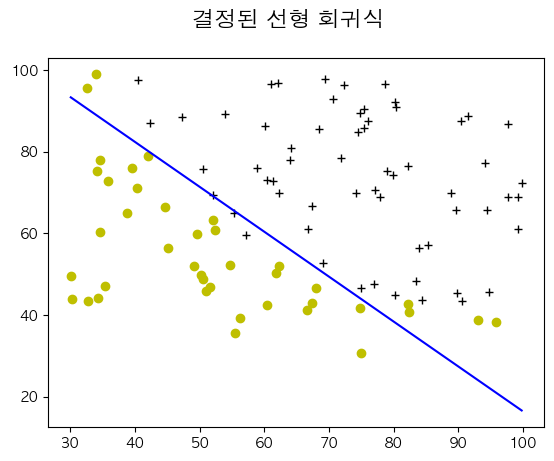

In [78]:
plot_decision_boundary(w, b, X_train, y_train)
plt.suptitle('결정된 선형 회귀식', fontsize=16)
plt.show()

### 1-7. 로지스틱 회귀 분석 예측 결과

* 0 혹은 1로 결정된 값을 출력

In [79]:
def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
   
    # Loop over each example
    for i in range(m):
        z_wb = 0
        for j in range(n): 
            z_wb += X[i, j] * w[j]
        z_wb += b
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        if f_wb < 0.5:
            p[i] = 0
        else:
            p[i] = 1
        
    return p

predict_test(predict)

All tests passed!


* training set에 대한 정확도 계산

In [80]:
#Compute accuracy on our training set
p = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 92.000000


---

## 2_Regularized_Logistic_Regression

### 2-1. 문제 상황
* 제조 공장의 마이크로칩이 품질 보증을 통과하는지 여부를 예측
* 공장의 제품 관리자는 두 가지 다른 테스트에서 일부 마이크로칩에 대한 테스트 결과를 바탕으로 통과 여부 예측

### Load data

In [81]:
# load dataset
X_train, y_train = load_data("./resource_W3/data/ex2data2.txt")

In [82]:
# print X_train
print("X_train:", X_train[:5])
print("Type of X_train:",type(X_train))

# print y_train
print("y_train:", y_train[:5])
print("Type of y_train:",type(y_train))

X_train: [[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]
 [-0.21371   0.69225 ]
 [-0.375     0.50219 ]
 [-0.51325   0.46564 ]]
Type of X_train: <class 'numpy.ndarray'>
y_train: [1. 1. 1. 1. 1.]
Type of y_train: <class 'numpy.ndarray'>


* 시각화

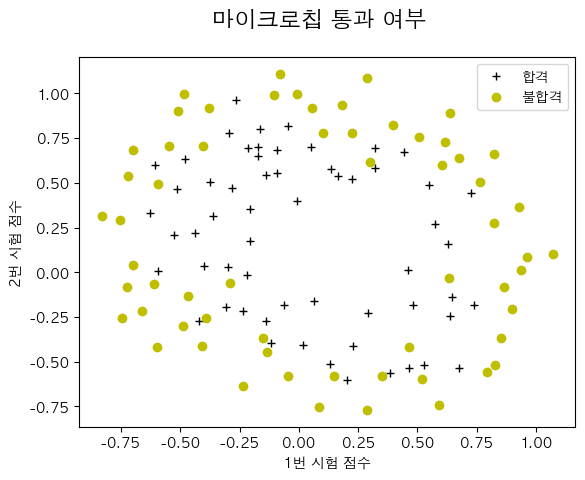

In [84]:
# Plot examples
plot_data(X_train, y_train[:], pos_label="합격", neg_label="불합격")

plt.suptitle('마이크로칩 통과 여부', fontsize=16)
plt.ylabel('2번 시험 점수') 
plt.xlabel('1번 시험 점수') 
plt.legend(loc="upper right")
plt.show()

### 2-2. Feature mapping

- 제공된 함수 `map_feature`은 특징을 6제곱까지 $x_1$과 $x_2$의 모든 다항식 항에 매핑함

In [86]:
print("Original shape of data:", X_train.shape)
mapped_X =  map_feature(X_train[:, 0], X_train[:, 1])
print("Shape after feature mapping:", mapped_X.shape)

Original shape of data: (118, 2)
Shape after feature mapping: (118, 27)


In [87]:
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", mapped_X[0])

X_train[0]: [0.051267 0.69956 ]
mapped X_train[0]: [5.12670000e-02 6.99560000e-01 2.62830529e-03 3.58643425e-02
 4.89384194e-01 1.34745327e-04 1.83865725e-03 2.50892595e-02
 3.42353606e-01 6.90798869e-06 9.42624411e-05 1.28625106e-03
 1.75514423e-02 2.39496889e-01 3.54151856e-07 4.83255257e-06
 6.59422333e-05 8.99809795e-04 1.22782870e-02 1.67542444e-01
 1.81563032e-08 2.47750473e-07 3.38066048e-06 4.61305487e-05
 6.29470940e-04 8.58939846e-03 1.17205992e-01]


### 2-3. 정규화된 로지스틱 회귀에서의 비용함수

$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

* 위 1-4. 에서 작성한 `compute_cost`를 활용
* w^2에 대한 식을 포함한 `compute_cost_reg`를 작성

In [90]:
def compute_cost_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
      X : (array_like Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : (array_like Shape (n,)) Values of bias parameter of the model
      lambda_ : (scalar, float)    Controls amount of regularization
    Returns:
      total_cost: (scalar)         cost 
    """

    m, n = X.shape
    
    # compute_cost 함수를 이용해 cost를 계산
    cost_without_reg = compute_cost(X, y, w, b) 
    
    reg_cost = np.sum(w**2)
        
    # 전체 식 작성
    total_cost = cost_without_reg + (lambda_/(2 * m)) * reg_cost

    return total_cost

compute_cost_reg_test(compute_cost_reg)

All tests passed!


### 2-4. 경사하강법 